<a href="https://colab.research.google.com/github/Iasonaspg/ser-repo/blob/main/ser3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

In [ ]:
!pip install thundersvm

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Acted Emotional Speech Dynamic Database.zip (Unzipped Files)/Acted Emotional Speech Dynamic Database/')
!ls 

 anger						      feature_train_vector.csv
 cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb   happiness
 disgust					      sadness
 fear						     'Tools and Documentation'
 feature_test_vector.csv


In [3]:
import numpy as np
import scipy
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display

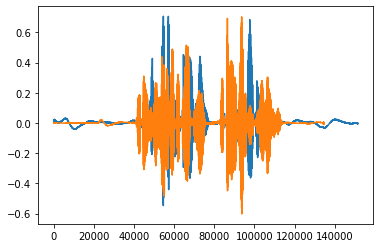

In [4]:
# load audio file
from pathlib import Path
fs = 22050
n_fft, hop = 1024, 256

def get_train_wav_dir(dir_name,fs=44100):
  return [ librosa.load(p,fs)[0] for p in Path().glob('./' + dir_name + '/train' + '/*.wav') ]

def get_test_wav_dir(dir_name,fs=44100):
  return [ librosa.load(p,fs)[0] for p in Path().glob('./' + dir_name + '/test' + '/*.wav') ]



emotions = ["sadness","happiness","anger","fear","disgust"]

# list that contain lists of numpy arrays
train_wav = []
test_wav = []
for emotion in emotions:
  train_wav.append(get_train_wav_dir(emotion,fs))
  test_wav.append(get_test_wav_dir(emotion,fs))

#anger_train_wav = get_train_wav_dir("sadness",fs)
#anger_test_wav = get_test_wav_dir("sadness",fs)
#print(len(anger_train_wav))
#print(len(anger_train_wav[0]))
#happy_train_wav = get_train_wav_dir("happiness",fs)
#happy_test_wav = get_test_wav_dir("happiness",fs)
#print('fs: ', fs, 'Hz', 'Frame size: ', n_fft/fs, 'Seconds')
#print(anger_train_wav[0].shape, 'min: ', anger_train_wav[0].min(),' max:', anger_train_wav[0].max())
#print(happy_train_wav[0].shape, 'min: ', happy_train_wav[0].min(),' max:', happy_train_wav[0].max())
# Diplay media player
#display(Audio(anger_train_wav[0], rate=fs))
display(Audio(train_wav[1][0], rate=fs))
plt.plot(train_wav[0][0])
plt.plot(train_wav[1][0])
plt.show()

In [25]:
display(Audio(train_wav[1][0], rate=fs))
print(train_wav[1][0].shape)

(134473,)


In [ ]:
def spectrogram(wav,n_fft=256,hop_length=128,window='hamming'):
    D = librosa.stft(wav, n_fft, hop_length, window='hamming')
    spect, _ = librosa.magphase(D, power=1)
    return spect

spec = spectrogram(wav,256)

print('Spectrogram shape', spec.shape)
print('{min %.2f} {mean %.2f} {max %.2f}' % (np.amin(spec), np.mean(spec), np.amax(spec)))
plt.plot(wav)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(spec, origin='lower')
plt.show()

plt.hist(spec)
plt.show()

log_spec = librosa.power_to_db(spec ** 2, ref=np.min)
plt.figure(figsize=(10,10))
plt.imshow(log_spec, origin='lower',vmin=-60)
plt.show()
plt.hist(log_spec)
plt.xlabel('Magnitude (dB)')
plt.show()

In [5]:
from librosa.feature import spectral

# Gets a list of wav signals and returns a numpy array of features x nFrames_total and a list of len(input) containing the nFrames per signal
def extract_features(wav,label):
  spectral_centroid = spectral.spectral_centroid(wav[0], sr=fs, n_fft=n_fft, hop_length=hop)
  spectral_rolloff = spectral.spectral_rolloff(wav[0], sr=fs, hop_length=hop,roll_percent=0.30)
  zero_crossing_rate = spectral.zero_crossing_rate(wav[0], frame_length=n_fft, hop_length=hop)
  mfcc = librosa.feature.mfcc(wav[0], sr=fs, n_fft=n_fft, hop_length=hop, n_mfcc=7)
  desired_mfcc = np.concatenate((mfcc[1:2,:],mfcc[4:5,:],mfcc[6:7,:]),axis=0)
  mfcc_delta = librosa.feature.delta(desired_mfcc, order=1, mode='nearest')
  mfcc_delta2 = librosa.feature.delta(desired_mfcc, order=2, mode='nearest')
  feature_vector = np.concatenate((spectral_centroid,spectral_rolloff,zero_crossing_rate,desired_mfcc,mfcc_delta,mfcc_delta2),axis=0)
  nFrames = [0 for i in range(len(wav))]
  nFrames[0] = spectral_centroid.shape[1]
  for i in range(1,len(wav)):
    spectral_centroid = spectral.spectral_centroid(wav[i], sr=fs, n_fft=n_fft, hop_length=hop)
    spectral_rolloff = spectral.spectral_rolloff(wav[i], sr=fs, hop_length=hop,roll_percent=0.30)
    zero_crossing_rate = spectral.zero_crossing_rate(wav[i], frame_length=n_fft, hop_length=hop)
    mfcc = librosa.feature.mfcc(wav[i], sr=fs, n_fft=n_fft, hop_length=hop, n_mfcc=7)
    desired_mfcc = np.concatenate((mfcc[1:2,:],mfcc[4:5,:],mfcc[6:7,:]),axis=0)
    mfcc_delta = librosa.feature.delta(desired_mfcc, order=1, mode='nearest')
    mfcc_delta2 = librosa.feature.delta(desired_mfcc, order=2, mode='nearest')
    feature_vector1 = np.concatenate((spectral_centroid,spectral_rolloff,zero_crossing_rate,desired_mfcc,mfcc_delta,mfcc_delta2),axis=0)
    feature_vector = np.concatenate((feature_vector,feature_vector1),axis=1)
    nFrames[i] = spectral_centroid.shape[1]
  label_vec = [label for i in range(feature_vector.shape[1])]
  #print(feature_vector.shape[1])
  feature_vector = np.concatenate((feature_vector,np.array([label_vec])),axis=0)
  return feature_vector, nFrames

test_nframes = []
feature_train_vector, _ = extract_features(train_wav[0],0)
feature_test_vector, test_nframe = extract_features(test_wav[0],0)
test_nframes.append(test_nframe)
for i in range(1,len(train_wav)):
  train_feat_vec, _ = extract_features(train_wav[i],i)
  feature_train_vector = np.concatenate((feature_train_vector,train_feat_vec),axis=1)
  test_feat_vec, test_nframe = extract_features(test_wav[i],i)
  test_nframes.append(test_nframe)
  feature_test_vector = np.concatenate((feature_test_vector,test_feat_vec),axis=1)
  print(len(train_wav[i]))
  print(train_wav[i][60].shape)


# anger_train_feat_vec, anger_train_nframes = extract_features(anger_train_wav,0)
# anger_test_feat_vec, anger_test_nframes = extract_features(anger_test_wav,0)
# happy_train_feat_vec, _ = extract_features(happy_train_wav,1)
# happy_test_feat_vec, happy_test_nframes = extract_features(happy_test_wav,1)
# feature_train_vector = np.concatenate((anger_train_feat_vec,happy_train_feat_vec),axis=1)
# feature_test_vector = np.concatenate((anger_test_feat_vec,happy_test_feat_vec),axis=1)


#print(spectral_centroid.shape)
#spectral_bandwidth = spectral.spectral_bandwidth(y=wav, sr=fs, hop_length=hop)
#spectral_contrast = spectral.spectral_contrast(y=wav, sr=fs, hop_length=hop, fmin=80.)
#spectral_flatness = spectral.spectral_flatness(y=wav, hop_length=hop)
#chromagram = librosa.feature.chroma_stft(wav, sr=fs, hop_length=hop)
# NO: rms = rms(y=wav, sr=fs, hop_length=hop)
# NO: Variance etc
#print(spectral_bandwidth.shape)
#print(spectral_contrast.shape)
#print(spectral_rolloff.shape)
#print(spectral_flatness.shape)
#print(zero_crossing_rate.shape)
#print(chromagram.shape)

#feature_vector = np.concatenate((spectral_centroid, 
#                                 spectral_bandwidth,
#                                 spectral_contrast,
#                                 spectral_rolloff,
#                                 spectral_flatness,
#                                 zero_crossing_rate,
#                                 chromagram), axis=0)

#feature_vector = np.concatenate((spectral_centroid,spectral_rolloff,zero_crossing_rate),axis=0)
#feature_vector2 = np.concatenate((spectral_centroid2,spectral_rolloff2,zero_crossing_rate2),axis=0)


print(feature_test_vector.shape)
#print(happy_train_feat_vec.shape)
print('=')
print(feature_train_vector.shape)
#print(feature_vector[:,0:2])

102
(70979,)
103
(48067,)
103
(62299,)
104
(105840,)
(13, 30864)
=
(13, 182942)


In [11]:
a = np.asarray(feature_train_vector)
np.savetxt("feature_train_vector.csv", a, delimiter=",")

a = np.asarray(feature_test_vector)
np.savetxt("feature_test_vector.csv", a, delimiter=",")

In [15]:
import sklearn
normalizer = sklearn.preprocessing.Normalizer().fit(feature_train_vector[0:12,:].T)

feature_train_norm = normalizer.transform(feature_train_vector[0:12,:].T) 
feature_test_norm = normalizer.transform(feature_test_vector[0:12,:].T)
print(feature_train_vector.shape,feature_train_norm.shape)

(13, 182942) (182942, 12)


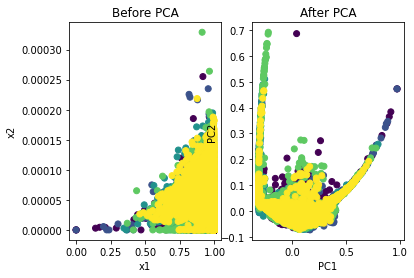

In [29]:
#from sklearn import decomposition
pca = sklearn.decomposition.PCA(n_components=12)
pca_train = pca.fit_transform(feature_train_norm[:,0:12])

fig, axes = plt.subplots(1,2)
axes[0].scatter(feature_train_norm[:,0], feature_train_norm[:,2], c=feature_train_vector[12,].T)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(pca_train[:,0], pca_train[:,2], c=feature_train_vector[12,].T)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()



In [34]:
print(pca.explained_variance_ratio_,"\n")
#print(pca.explained_variance_)
print(abs( pca.components_ )[0],"\n")
print(abs( pca.components_ )[1],"\n")
print(abs( pca.components_ )[2],"\n")


[8.85218957e-01 7.91806685e-02 2.23551070e-02 7.08027970e-03
 4.97543544e-03 7.30576204e-04 1.69887827e-04 1.53597701e-04
 7.86385888e-05 3.48049286e-05 2.20413559e-05 6.30384499e-09] 

[3.45112368e-01 9.35741448e-01 6.87565783e-05 5.54941602e-02
 4.20602111e-02 2.08829117e-02 2.98043131e-04 3.47383419e-05
 4.95976343e-05 3.40604947e-04 6.50997368e-04 2.10178585e-05] 

[3.84320883e-02 4.91644671e-02 5.59315122e-05 9.94002114e-01
 7.51416931e-02 4.49672733e-02 1.17567658e-03 1.94178220e-04
 1.93301564e-03 1.97639156e-02 1.21480164e-03 2.20792000e-04] 

[6.62655913e-01 2.13831495e-01 1.26369622e-04 7.71046286e-02
 5.66613256e-01 4.33238611e-01 4.37803461e-03 2.77758353e-03
 3.37261147e-03 1.91120817e-02 7.17379725e-03 4.10191543e-03] 



In [35]:
from sklearn import svm
from thundersvm import SVC
import time
#X = np.concatenate((feature_vector[:,0:50000],happy_feat_vec[:,0:50000]),axis=1)
#y = np.concatenate((np.zeros((50000)),np.ones((50000))),axis=0)

#print(X.shape)
#print(y.shape)
clf = svm.SVC()
str = time.time()
clf.fit(feature_train_vector[0:12,:].T, feature_train_vector[12,:].T)
print(time.time()-str)
#print(feature_vector[:,3:5])
#clf.predict(feature_vector[:,200:240].T)
#clf_gpu = SVC()
#str = time.time()
#clf_gpu.fit(feature_train_vector[0:12,:].T, feature_train_vector[12,:].T)
#print(time.time()-str)

2382.715900182724
1085.5837166309357


In [10]:
import statistics 
from statistics import mode 

def get_label(y):
  return mode(y)



In [ ]:
from sklearn.metrics import accuracy_score

print("CPU: \n")

accuracy_list = []

for k in test_nframes:
  i = 0
  for j in k:
    pred = clf.predict(feature_test_vector[0:12,i:i+j].T)
    acc = accuracy_score(feature_test_vector[12,i:i+j].T,pred,True)
    accuracy_list.append(acc)
    print(acc)
    i = i + j

print("Mean CPU accuracy: ", np.mean(accuracy_list))

#print("GPU: \n")
#
#for k in test_nframes:
#  i = 0
#  for j in k:
#    pred = clf_gpu.predict(feature_test_vector[0:12,i:i+j].T)
#    print(accuracy_score(feature_test_vector[12,i:i+j].T,pred,True))
#    i = i + j

pred = clf.predict(feature_test_vector[0:12,:].T)
print(accuracy_score(feature_test_vector[12,:].T,pred,True))


0.9693877551020408
0.6334106728538283
0.39344262295081966
0.6114519427402862
0.9240506329113924
0.7559681697612732
0.27053140096618356
0.9571823204419889
0.9859649122807017
0.818639798488665
0.5774193548387097
0.6749226006191951
0.8518518518518519
0.5850622406639004
0.8397790055248618
0.42924528301886794
0.66
0.8598382749326146
0.9846938775510204
1.0
1.0
1.0
1.0
1.0
1.0
0.9709944751381215
0.9105263157894737
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.6779194208372679


In [21]:
from sklearn.linear_model import LogisticRegression
clf_lgr = LogisticRegression(C=100,random_state=0,solver='liblinear',max_iter=600)
clf_lgr.fit(feature_train_vector[0:12,:].T, feature_train_vector[12,:].T)
clf_lgr.predict(feature_test_vector[0:12,:].T)
print(clf_lgr.score(feature_train_vector[0:12,:].T, feature_train_vector[12,:].T))

pred = clf_lgr.predict(feature_test_vector[0:12,:].T)
print(accuracy_score(feature_test_vector[12,:].T,pred,True))

0.33158050092379004
0.32371047174701917


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_lgr = LogisticRegression(C=100,random_state=0,solver='liblinear',max_iter=600)
clf_lgr.fit(feature_train_norm, feature_train_vector[12,:].T)
clf_lgr.predict(feature_test_norm)
print(clf_lgr.score(feature_train_norm[:,0:12], feature_train_vector[12,:].T))

pred = clf_lgr.predict(feature_test_norm[:,0:12])
print(accuracy_score(feature_test_vector[12,].T,pred,True))

In [22]:
print("CPU: \n")

accuracy_list = []

for k in test_nframes:
  i = 0
  for j in k:
    pred = clf_lgr.predict(feature_test_vector[0:12,i:i+j].T)
    acc = accuracy_score(feature_test_vector[12,i:i+j].T,pred,True)
    #acc = clf_lgr.score(feature_test_vector[0:12,i:i+j].T,feature_test_vector[12,i:i+j])
    accuracy_list.append(acc)
    #print(acc)
    i = i + j
  
print("Mean CPU accuracy: ", np.mean(accuracy_list))

CPU: 

Mean CPU accuracy:  0.6410781825479489


In [20]:
print("CPU: \n")

accuracy_list = []

for k in test_nframes:
  i = 0
  for j in k:
    pred = clf_lgr.predict(feature_test_norm[i:i+j,])
    acc = accuracy_score(feature_test_vector[12,i:i+j].T,pred,True)
    #acc = clf_lgr.score(feature_test_norm,feature_test_vector[12,i:i+j])
    accuracy_list.append(acc)
    #print(acc)
    i = i + j
  
print("Mean CPU accuracy: ", np.mean(accuracy_list))

CPU: 

Mean CPU accuracy:  0.5776524845968057
